In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from collections import defaultdict
import glob
from collections import Counter
import os

import tqdm
import optuna
import warnings
warnings.filterwarnings('ignore')

In [2]:
chosen_features = ['feature_80', 'feature_421', 'feature_48', 'feature_47', 'feature_451', 'feature_234', 'feature_131', 'feature_244', 'feature_223', 'feature_428', 'feature_467', 'feature_166', 'feature_383', 'feature_212', 'feature_424', 'feature_434', 'feature_151', 'feature_11', 'feature_435', 'feature_18', 'feature_318', 'feature_495', 'feature_98', 'feature_364', 'feature_119', 'feature_230', 'feature_462', 'feature_242', 'feature_197', 'feature_139', 'feature_132', 'feature_325', 'feature_323', 'feature_114', 'feature_87', 'feature_332', 'feature_470', 'feature_14', 'feature_147', 'feature_365', 'feature_331', 'feature_345', 'feature_336', 'feature_353', 'feature_334', 'feature_481', 'feature_157', 'feature_137', 'feature_369', 'feature_366', 'feature_359', 'feature_81', 'feature_246', 'feature_153', 'feature_341', 'feature_238', 'feature_452', 'feature_100', 'feature_12', 'feature_349', 'feature_356', 'feature_314', 'feature_480', 'feature_272', 'feature_42', 'feature_35', 'feature_295', 'feature_194', 'feature_200', 'feature_1', 'feature_296', 'feature_291', 'feature_129', 'feature_279', 'feature_439', 'feature_76', 'feature_361', 'feature_86', 'feature_351', 'feature_473', 'feature_301', 'feature_346', 'feature_494', 'feature_286', 'feature_367', 'feature_493', 'feature_330', 'feature_273', 'feature_344', 'feature_333', 'feature_97', 'feature_455', 'feature_358', 'feature_186', 'feature_456', 'feature_44', 'feature_309', 'feature_320', 'feature_270', 'feature_154', 'feature_390', 'feature_138', 'feature_412', 'feature_164', 'feature_310', 'feature_328', 'feature_363', 'feature_82', 'feature_368', 'feature_303', 'feature_45', 'feature_319', 'feature_386', 'feature_350', 'feature_199', 'feature_352', 'feature_19', 'feature_305', 'feature_68', 'feature_402', 'feature_347', 'feature_472', 'feature_239', 'feature_461', 'feature_276', 'feature_51', 'feature_294', 'feature_458', 'feature_342', 'feature_292', 'feature_360', 'feature_357', 'feature_464', 'feature_340', 'feature_444', 'feature_378', 'feature_394', 'feature_168', 'feature_278', 'feature_222', 'feature_384', 'feature_380', 'feature_373', 'feature_498', 'feature_398', 'feature_407', 'feature_264', 'feature_66', 'feature_311', 'feature_408', 'feature_93', 'feature_73', 'feature_117', 'feature_376', 'feature_335', 'feature_460', 'feature_126', 'feature_313', 'feature_442', 'feature_16', 'feature_496', 'feature_465', 'feature_231', 'feature_144', 'feature_422', 'feature_283', 'feature_324', 'feature_202', 'feature_355', 'feature_429', 'feature_39', 'feature_337', 'feature_482', 'feature_468', 'feature_5', 'feature_469', 'feature_396', 'feature_315', 'feature_84', 'feature_287', 'feature_106', 'feature_372', 'feature_362', 'feature_466', 'feature_450', 'feature_400', 'feature_475', 'feature_354', 'feature_348', 'feature_488', 'feature_492', 'feature_490', 'feature_457', 'feature_290', 'feature_326', 'feature_343', 'feature_391', 'feature_491', 'feature_385', 'feature_374', 'feature_463', 'feature_339', 'feature_445', 'feature_95', 'feature_316', 'feature_471', 'feature_389', 'feature_497', 'feature_441', 'feature_88', 'feature_133', 'feature_387', 'feature_225', 'feature_338', 'feature_304', 'feature_293', 'feature_85', 'feature_375', 'feature_487', 'feature_425', 'feature_484', 'feature_448', 'feature_371', 'feature_440', 'feature_453', 'feature_459', 'feature_447', 'feature_485', 'feature_120', 'feature_281', 'feature_483', 'feature_284', 'feature_478', 'feature_122', 'feature_403', 'feature_449', 'feature_329', 'feature_443', 'feature_74', 'feature_71', 'feature_477', 'feature_322', 'feature_94', 'feature_282', 'feature_405', 'feature_446', 'feature_312', 'feature_17', 'feature_409', 'feature_306', 'feature_327', 'feature_474', 'feature_499', 'feature_476', 'feature_195', 'feature_218', 'feature_99', 'feature_411', 'feature_8', 'feature_321', 'feature_404', 'feature_79', 'feature_250', 'feature_489', 'feature_175', 'feature_113', 'feature_288', 'feature_289', 'feature_486', 'feature_317', 'feature_437', 'feature_370', 'feature_232', 'feature_229', 'feature_259'][:150] + ['feature_265', 'feature_490', 'feature_173']

In [3]:
categorial_features = ['feature_17', 'feature_21', 'feature_22', 'feature_27', 'feature_31', 'feature_43', 'feature_61', 'feature_64', 'feature_80', 'feature_83', 'feature_92', 'feature_133', 'feature_143', 'feature_166', 'feature_173', 'feature_191', 'feature_201', 'feature_209', 'feature_251', 'feature_253', 'feature_299', 'feature_300', 'feature_343', 'feature_347', 'feature_382', 'feature_392', 'feature_405', 'feature_406', 'feature_423', 'feature_434', 'feature_446', 'feature_449', 'feature_459', 'feature_490', 'feature_492']

In [4]:
train_dfs = [pd.read_csv(f"Files/Train/train_{i+1}.csv") for i in range(1, 6)]

In [5]:
# ignore_features = ['target']+categorial_features
ignore_features = ['target', 'id', 'smpl']

In [8]:
model_categorial_f = list(np.intersect1d(categorial_features, train_dfs[0][chosen_features].columns))
model_categorial_f

['feature_166',
 'feature_173',
 'feature_347',
 'feature_434',
 'feature_490',
 'feature_80']

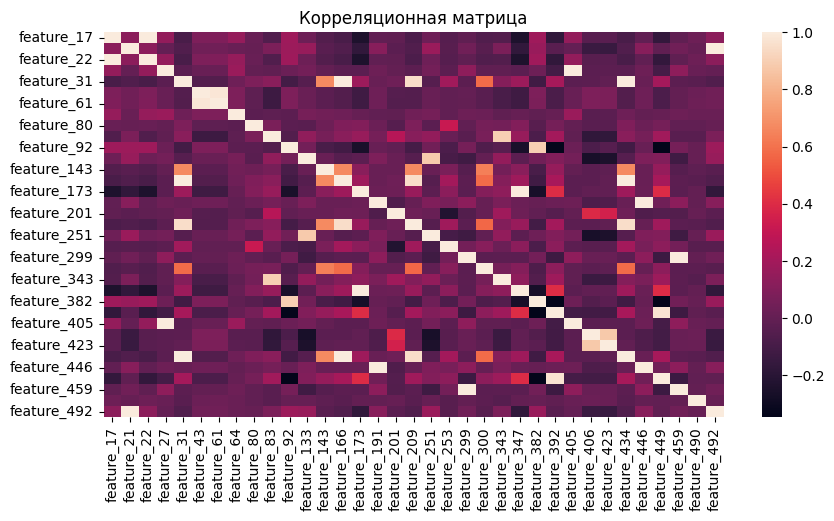

In [9]:
corr_train_df = train_dfs[1][categorial_features]
fig, ax = plt.subplots(figsize=(10, 5))
plt.title('Корреляционная матрица')
sns.heatmap(corr_train_df.corr(), fmt='.2g');

In [10]:
def get_correlated_features(corr_matrix, corr_threshold=0.9):
    correlated_features = set()
    
    for col in tqdm.tqdm(corr_matrix.columns, desc='Выявление коррелированных фичей'):
        if col in correlated_features:
            continue
            
        correlated_cols = corr_matrix.index[np.abs(corr_matrix[col]) >= corr_threshold].tolist()
        
        if len(correlated_cols) > 1:
            print(f'{col} -> {correlated_cols}')
            correlated_features.update(correlated_cols[1:])
    
    return list(correlated_features)

In [11]:
clean_df = corr_train_df.copy()

corr_mx = pd.DataFrame(np.corrcoef(clean_df.values, rowvar=False),
                       columns=clean_df.columns,
                       index=clean_df.columns)

corr_features = get_correlated_features(corr_mx, corr_threshold=0.9)
print(f'Коррелированные фичи \n{corr_features}')

Выявление коррелированных фичей: 100%|███████████████████████████████████████████████| 35/35 [00:00<00:00, 1895.84it/s]

feature_17 -> ['feature_17', 'feature_22']
feature_21 -> ['feature_21', 'feature_492']
feature_27 -> ['feature_27', 'feature_405']
feature_31 -> ['feature_31', 'feature_166', 'feature_209', 'feature_434']
feature_43 -> ['feature_43', 'feature_61']
feature_173 -> ['feature_173', 'feature_347']
feature_191 -> ['feature_191', 'feature_446']
feature_299 -> ['feature_299', 'feature_459']
feature_392 -> ['feature_392', 'feature_449']
Коррелированные фичи 
['feature_22', 'feature_347', 'feature_166', 'feature_434', 'feature_449', 'feature_492', 'feature_446', 'feature_459', 'feature_61', 'feature_405', 'feature_209']
